In [254]:
import numpy as np
from scipy.optimize import linprog 
from twinsvm import twinsvmclassifier
import random
import sys
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [255]:
def optimize(X,y,delta, alpha):
    (m,n) = X.shape
    K = (y == 0).sum()
    M = (y == 1).sum()
    A = np.zeros((2*n,m))
    B = np.zeros((m))
    for i in range(m):
        if y[i] == 0:     
            V = np.zeros((2,m))
            V[0][i] = 1
            V[1][i] = -1
            A = np.vstack((A,V))
            for j in range(n):
                A[j][i] = X[i][j]
                A[j+n][i] = -1*X[i][j]
                B[i] = -delta
        else:  
            V = np.zeros((2,m))
            V[0][i] = -1
            V[1][i] = 1
            A = np.vstack((A,V)) 
            for j in range(n):
                A[j][i] = X[i][j]
                A[j+n][i] = -1*X[i][j]
                B[i] = delta
    A = np.vstack((A, np.zeros((n,m))))   # dimension of A is 2n+2m+n, m
    s1 = np.zeros((3*n+2*m))
    s2 = np.zeros((3*n+2*m))
    W = np.zeros((2*n+2*m+n))
    for i in range(m):
        if y[i] == 0:
            W[2*i+2*n] = 0                  #
            W[2*i+2*n+1] = 1/K              #
            s2[2*n+2*i] = -1
        else:
            W[2*i+2*n] = 0                  #
            W[2*i+2*n+1] = 1/M              #
            s1[2*n+2*i] = -1
    for i in range(n):
        W[i+2*n+2*m] = alpha   ##########
    A = A.T
    #Ax=B the equality contraints
    C = np.zeros((2*n, 3*n+2*m))
    D = np.zeros((2*n+2))
    D[2*n+2-1] = -1
    D[2*n+2-2] = -1
    for i in range (n):
        C[i,i] = 1
        C[i+n,i] = -1
        C[i, i+n] = -1
        C[i+n, i+n] = 1
        C[i, i+2*n+2*m] = -1
        C[i+n, i+2*n+2*m] = -1
        # Cx<=D
    C = np.vstack((C, s1))
    C = np.vstack((C, s2))
    
    res = linprog(W, A_ub=C, b_ub=D, A_eq=A, b_eq=B,  bounds=(0, None), method = 'simplex') 
    wd = res.x[:n]-res.x[n:2*n]
    si1 = np.zeros((m))
    si2 = np.zeros((m))
    for i in range(m):
        si1[i] = res.x[i*2+2*n]
    for i in range(m):
        si2[i] = res.x[i*2+2*n+1]
    print("wd:"+str(wd))
    return np.matrix(wd),None



In [256]:
def y_hat(X, weights, delta, y,twin_svm_en,clf):
    if(twin_svm_en == 0):
        n = len(X)
        y_res = np.asarray(np.dot(weights, X.T))
        for i in range(n):
            if y_res[0][i] >= delta:
                y_res[0][i] = 1
            elif y_res[0][i] <= -delta:
                y_res[0][i] = 0
            else :
                y_res[0][i] = 1-y[i]
    else:
        Xx = X[:,1:len(X[0])]
        y_pred = clf.predict(Xx)
        y_res = np.array([y_pred])
        
    return y_res[0]


In [257]:
def classes(y,y_res):
    C1 = []
    C2 = []
    C3 = []
    C4 = []
    y = y.astype(int)
    y_res = y_res.astype(int)
    for i in range(len(y_res)): 
        if y[i] == 0 and y_res[i] == 0:
            C1.append(i)
        if y[i] == 1 and y_res[i] == 1:
            C2.append(i)
        if y[i] == 1 and y_res[i] == 0:
            C3.append(i)
        if y[i] == 0 and y_res[i] == 1:
            C4.append(i)
    return C1, C2, C3, C4


In [258]:

#plane1 < plane2 => class 0
#plane1 >= plane2 => class 1
# plane1-plane2 < 0 => class 0 
# plane1-plane2 >= 0 => class 1
#C3 => desired 1 we get 0
#so plane1 < plane2 
#   plane1-plane2 < 0
#   Wa decided by min(plane1-plane2)
def find_Wa(X, C3, weights):
    res = sys.maxsize
    y=0
    ans =0
    for i in C3:
        if(weights.shape[1]==X.shape[1]):
            y = np.asarray(np.dot(weights, X[i].T))
            res = min(res, y[0][0])
            ans = 1-res+0.0001
        else:
            print("twinsvm")
            XX = X[i,1:len(X[i])]
            weights = np.asarray(weights)
            X= np.asarray(X)
            b1 = weights[0][0]
            w1 = weights[0][1:X.shape[1]]
            b2 = weights[0][X.shape[1]]
            w2 = weights[0][X.shape[1]+1:2*(X.shape[1])]
            w1mod = np.linalg.norm(w1)
            w2mod = np.linalg.norm(w2)
            y1 = np.dot(XX,w1)+ b1
            y2 = np.dot(XX,w2)+ b2
            distFromPlane1 = y1/w1mod 
            distFromPlane2 = y2/w2mod 
            dis = (distFromPlane1 - distFromPlane2)
            res = min(res, dis)
            ans = -res+0.000001
    return ans

#C4 => desired 0 we get 1
#so plane1 >= plane2
#   plane1-plane2 >= 0
#   Wb decided by max(plane1-plane2)
def find_Wb(X, C4, weights):
    res = -sys.maxsize-1
    y=0
    ans = 0
    for i in C4:
        if(weights.shape[1]==X.shape[1]):
            y = np.asarray(np.dot(weights, X[i].T))
            res = max(res, y[0][0])
            ans = -1-res-0.0000001
        else:
            print("twinsvm")
            XX = X[i,1:len(X[i])]
            weights = np.asarray(weights)
            X= np.asarray(X)
            b1 = weights[0][0]
            w1 = weights[0][1:X.shape[1]]
            b2 = weights[0][X.shape[1]]
            w2 = weights[0][X.shape[1]+1:2*(X.shape[1])]
            w1mod = np.linalg.norm(w1)
            w2mod = np.linalg.norm(w2)
            y1 = np.dot(XX,w1)+ b1
            y2 = np.dot(XX,w2)+ b2
            distFromPlane1 = y1/w1mod 
            distFromPlane2 = y2/w2mod 
            dis = (distFromPlane1 - distFromPlane2)
            res = max(res, dis)
            ans = -res-0.000001
    return ans

In [259]:
def quantize(a,b,twin_node,twin_classifier,XX):
    if(twin_node == 0):
        res = np.dot(a,b.T)
        print("res_before_quant:"+str(res))
        res = res.astype(int)
        for j in range(res.shape[0]):
            if(res[j][0] >= delta):
                res[j][0] = 1
            elif(res[j][0] <= -delta):
                res[j][0] = 0
            else:
                print("delta condition not met")
        print("res_after_quant:"+str(res))
    else:
        Xd = a[:,1:XX.shape[1]]
        if(a.shape[1] > XX.shape[1]):
            XAB = a[:,XX.shape[1]:a.shape[1]]
        else:
            XAB = np.array([[]])
        print("twin_svm_res")
        b1 = b[0][0]
        w1 = b[0][1:XX.shape[1]].reshape(XX.shape[1]-1,1)
        b2 = b[0][XX.shape[1]]
        w2 = b[0][XX.shape[1]+1:2*(XX.shape[1])].reshape(XX.shape[1]-1,1)
        wAB = b[0][2*(XX.shape[1]):b.shape[1]].reshape(-1,1)
        w1mod = np.linalg.norm(w1)
        w2mod = np.linalg.norm(w2)
        y1 = np.dot(Xd,w1)+ b1*np.ones((XX.shape[0],1))
        y2 = np.dot(Xd,w2)+ b2*np.ones((XX.shape[0],1))
        distFromPlane1 = y1/w1mod 
        distFromPlane2 = y2/w2mod 
        res = (distFromPlane1 - distFromPlane2) + np.dot(XAB,wAB)
        print("res_twin_bef:"+str(res))
        for j in range(res.shape[0]):
            if(res[j][0] >= 0):
                res[j][0] = 1
            elif(res[j][0] < 0):
                res[j][0] = 0
        print("res_twin_aft:"+str(res))
    return res

In [260]:

class Neuron:
    
    def __init__(self,n,twin_node,twin_classifier):
        self.X = np.zeros((1,n))
        self.inp = n
        self.A = None
        self.B = None
        self.twin_node = twin_node
        self.twin_classifier = twin_classifier
        self.weight = 0
        
    def insert(self,neuron_type, weight):     #### Type is a restricted variable, Type was always set to A, weigth to 1
        if neuron_type == 'A':
            self.A = Neuron(self.inp,0,None)
            self.A.weight = weight
            self.X = np.hstack((self.X, np.array([[weight]])))
        else:
            self.B = Neuron(self.inp,0,None)
            self.B.weight = weight
            self.X = np.hstack((self.X, np.array([[weight]])))
            
    def calculate(self,XX):
        if self.A != None and self.B != None:
            print("AB")
            y_1 = self.A.calculate(XX)
            y_2 = self.B.calculate(XX)
            print("y_1:"+str(y_1))
            print("y_2:"+str(y_2))
            res = quantize(np.hstack((XX, y_1, y_2)),self.X,self.twin_node,self.twin_classifier,XX)
            return res
        elif self.A != None:
            print("A")
            y_1 = self.A.calculate(XX)
            print("y_1:"+str(y_1))
            res = quantize(np.hstack((XX, y_1)),self.X,self.twin_node,self.twin_classifier,XX)
            return res
        elif self.B != None:
            print("B")
            y_2 = self.B.calculate(XX)
            print("y_2:"+str(y_2))
            res = quantize(np.hstack((XX, y_2)),self.X,self.twin_node,self.twin_classifier,XX)
            return res
        else:
            print("no child node")
            res = quantize(XX,self.X,self.twin_node,self.twin_classifier,XX)
            return res


In [261]:

def get_twin_classifier(X,y):
    while(True):
        C1value = random.uniform(0,5)
        C2value = random.uniform(0,5)
        params = {'Epsilon1': 0.1, 'Epsilon2': 0.1, 'C1': C1value, 'C2': C2value,'kernel_type':0,'kernel_param': 2}
        clf=twinsvmclassifier(**params)
        clf.fit(X,y)
        y_pred = clf.predict(X)
        C1,C2,C3,C4 = classes(y, y_pred)
        if(not(len(C1)==0 or len(C2)==0)):
            print("#######")
            print(C1)
            print(C2)
            print(C3)
            print(C4)
            print("#######")
            print("wb:"+str(clf.getwb()))
            return clf    
        

In [262]:
def twin(X,y):
    XX = X[:,1:len(X[0])]
    yy = y
    print("XX:"+str(XX))
    print("yy:"+str(yy))
    clf = get_twin_classifier(XX, yy)
    clf.fit(XX,yy)
    w1,b1,w2,b2 = clf.getwb()
    w1 = w1.T
    w2 = w2.T
    b1 = np.array([b1])
    b2 = np.array([b2])
    wd = np.hstack((b1,w1,b2,w2))
    print("wdtwin:"+str(wd))
    return wd,clf

In [263]:
def addneuron_A(X, y, W, C1, C3, C4, delta, alpha, curr_Neuron):
    n = X.shape[1]
    print('A')
    m = len(C1) + len(C3) + len(C4)
#     print(m)
    print("C1:")
    print((C1))
    print("C3:")
    print((C3))
    print("C4:")
    print((C4))
    y_A = np.zeros((m))
    X_A = np.zeros((m, n))
    for i in range(len(C1)):
        X_A[i] = X[C1[i]]
        y_A[i] = 0

    for i in range(len(C3)):
        X_A[i + len(C1)] = X[C3[i]]
        y_A[i + len(C1)] = 1

    for i in range(len(C4)):
        X_A[i + len(C1)+ len(C3)] = X[C4[i]]
        y_A[i + len(C1)+ len(C3)] = 0
    print("X_A:")
    print(X_A)
    print("y_A:")
    print(y_A)
    # print("X:"+str(X))
    # print("C3:"+str(C3))
    print("W:"+str(W))
    Wa = find_Wa(X, C3, W)
    print("Wa:"+str(Wa))
#         print(Wa)     
    W_A,clf = optimize(X_A, y_A, delta, alpha)
    y_res = y_hat(X_A, W_A, delta, y_A,0,clf)
    Cc1, Cc2, Cc3, Cc4 = classes(y_A, y_res)
    twin_svm_enable = int(len(Cc1)==0 or len(Cc2)==0)
    print("twin_svm_enable:"+str(twin_svm_enable))
    if(twin_svm_enable):
        W_A,clf = twin(X_A,y_A)
    curr_Neuron.insert('A', Wa)
    curr_Neuron.A.X = W_A
    curr_Neuron.A.twin_node = twin_svm_enable
    curr_Neuron.A.twin_classifier = clf
    return X_A, y_A, W_A,twin_svm_enable,clf


def addneuron_B(X, y, W, C2, C3, C4, delta, alpha, curr_Neuron):
    n = X.shape[1]
    print('B')
    m = len(C2) + len(C3) + len(C4)
    # print(m)
    y_B = np.zeros((m))
    X_B = np.zeros((m, n))
#         y_B = []
    print("C2:")
    print((C2))
    print("C3:")
    print((C3))
    print("C4:")
    print((C4))
    for i in range(len(C2)):
        X_B[i] = X[C2[i]]
        y_B[i] = 0

    for i in range(len(C3)):
        X_B[i + len(C2)] = X[C3[i]]
        y_B[i + len(C2)] = 0

    for i in range(len(C4)):
        X_B[i + len(C2)+ len(C3)] = X[C4[i]]
        y_B[i + len(C2)+ len(C3)] = 1

#     print(X_B)
    print("X_B:")
    print(X_B)
    print("y_B:")
    print(y_B)
    # print("X:"+str(X))
    # print("C4:"+str(C4))
    print("W:"+str(W))
    Wb = find_Wb(X, C4, W)
    print("Wb:"+str(Wb))
    W_B,clf = optimize(X_B, y_B, delta, alpha)
    y_res = y_hat(X_B, W_B, delta, y_B,0,clf)
    Cc1, Cc2, Cc3, Cc4 = classes(y_B, y_res)
    twin_svm_enable = int(len(Cc1)==0 or len(Cc2)==0)
    print("twin_svm_enable:"+str(twin_svm_enable))
    if(twin_svm_enable):
        W_B,clf = twin(X_B,y_B)
    curr_Neuron.insert('B', Wb)
    curr_Neuron.B.X = W_B
    curr_Neuron.B.twin_node = twin_svm_enable
    curr_Neuron.B.twin_classifier = clf
    return X_B, y_B, W_B,twin_svm_enable,clf


In [264]:
def accuracy(y_pred, y):
    count = 0
    if(len(y_pred) == len(y)):
        l = len(y)
        for i in range(l):
            if (y_pred[i] == y[i]):
                count+=1
        return count/l        
    else :
        print("Unequal lenghts of arrays!!")

In [265]:
accuracy(np.array([0,1,0,0,0,0]).reshape(6,1), np.array([1,0,0,0,0,1]))
# np.array([0,1,0,0,0,0]).shape

0.5

In [266]:
def classifier(X, y, W, delta, alpha, curr_Neuron,twin_en,clff):
    print("y:")
    print(y)
    y_res = y_hat(X, W, delta, y,twin_en,clff)
    print("y_res:")
    print(y_res)
    C1, C2, C3, C4 = classes(y, y_res)
    print("C1len:"+str(len(C1)))
    print("C2len:"+str(len(C2)))
    print("twin_en:"+str(twin_en))
    if len(C3)!= 0:
        X_A, y_A, W_A,twin_enable,clf = addneuron_A(X, y, W, C1, C3, C4, delta, alpha, curr_Neuron)
        classifier(X_A, y_A, W_A, delta, alpha, curr_Neuron.A,twin_enable,clf)
    if len(C4)!= 0:
        X_B, y_B, W_B,twin_enable,clf = addneuron_B(X, y, W, C2, C3, C4, delta, alpha, curr_Neuron)
        classifier(X_B, y_B, W_B, delta, alpha, curr_Neuron.B,twin_enable,clf)
    else:
        print("terminated")
        return 'Terminated'

In [319]:
training_err = []

def classifier2(X, y, W, delta, alpha, curr_Neuron, twin_en, clff, x_train, y_train):
    y_res = y_hat(X, W, delta, y,twin_en,clff)
    C1, C2, C3, C4 = classes(y, y_res)
    global training_err
#     training_error = ['oolala']
    
    if len(C3)!= 0:
        X_A, y_A, W_A,twin_enable,clf = addneuron_A(X, y, W, C1, C3, C4, delta, alpha, curr_Neuron)
        classifier2(X_A, y_A, W_A, delta, alpha, curr_Neuron.A,twin_enable,clf, x_train, y_train)
        a = curr_Neuron.calculate(x_train)
        training_err = np.concatenate((training_err, [accuracy(a, y_train)]))
    
    
    if len(C4)!= 0:
        X_B, y_B, W_B,twin_enable,clf = addneuron_B(X, y, W, C2, C3, C4, delta, alpha, curr_Neuron)
        classifier2(X_B, y_B, W_B, delta, alpha, curr_Neuron.B,twin_enable,clf, x_train, y_train)
        a = curr_Neuron.calculate(x_train)
        training_err = np.concatenate((training_err, [accuracy(a, y_train)]))
    
    else:
        print("terminated")
        print("training_err : " + str(training_err) + "    $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    return training_err

In [320]:
# X = np.array([[1,1,8],[1,1,1],[1,4,5],[1,4,4],[1,6,5],[1,6,4],[1,10,8],[1,10,1],[1,2,6],[1,2,3],[1,8,6],[1,8,3]])
# y=np.array([1,1,1,1,1,1,1,1,0,0,0,0])

annots = loadmat('Archive/1.mat')
X = annots['x']
y = annots['y']

X = np.concatenate((np.ones((X.shape[0],1)), X), axis = 1)   # Adding bias to the input
y = y.reshape(y.shape[0])   # Reshaping the output array
for i in range(len(y)):   # Converting the output into a (0,1) output rather than (-1,1)
    if(y[i]==-1):
        y[i]=0

X = X[:50,:]
y = y[:50]
        
alpha = 0
delta = 1
curr_Neuron = Neuron(3,0,None)
W, clf1 = optimize(X, y, delta, alpha)
curr_Neuron.X = W

err = classifier2(X, y, W, delta, alpha, curr_Neuron,0,clf1, X, y)


wd:[-8.97721436e+00  1.62445654e-01  2.48780053e-02 -3.96059107e-02
 -9.37915469e-02  7.84993518e-03  1.60374429e-01  4.08731666e+00
  5.03289073e-02]
A
C1:
[2, 5, 7, 9, 11, 13, 15, 16, 17, 18, 19, 21, 23, 24, 25, 27, 30, 32, 33, 36, 37, 42, 43, 46, 47]
C3:
[3, 6, 8, 12, 31, 34, 35, 40, 45]
C4:
[0, 4, 10, 20, 28, 39, 41, 48, 49]
X_A:
[[1.000e+00 1.000e+00 1.110e+02 6.200e+01 1.300e+01 1.820e+02 2.400e+01
  1.380e-01 2.300e+01]
 [1.000e+00 1.200e+01 1.060e+02 8.000e+01 0.000e+00 0.000e+00 2.360e+01
  1.370e-01 4.400e+01]
 [1.000e+00 2.000e+00 9.100e+01 6.200e+01 0.000e+00 0.000e+00 2.730e+01
  5.250e-01 2.200e+01]
 [1.000e+00 2.000e+00 9.900e+01 7.000e+01 1.600e+01 4.400e+01 2.040e+01
  2.350e-01 2.700e+01]
 [1.000e+00 3.000e+00 8.900e+01 7.400e+01 1.600e+01 8.500e+01 3.040e+01
  5.510e-01 3.800e+01]
 [1.000e+00 5.000e+00 8.800e+01 7.800e+01 3.000e+01 0.000e+00 2.760e+01
  2.580e-01 3.700e+01]
 [1.000e+00 1.000e+00 9.100e+01 5.400e+01 2.500e+01 1.000e+02 2.520e+01
  2.340e-01 2.300e+01]

wd:[-1.82017105e+01  1.21858712e-01  8.92074618e-03 -2.79276329e-02
 -1.02662247e-01  1.13343440e-02  3.51020715e-01  5.45177445e+00
  1.68915646e-01]
twin_svm_enable:0
A
C1:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
C3:
[21, 22, 24, 25, 26, 27]
C4:
[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
X_A:
[[1.000e+00 1.000e+00 1.110e+02 6.200e+01 1.300e+01 1.820e+02 2.400e+01
  1.380e-01 2.300e+01]
 [1.000e+00 1.200e+01 1.060e+02 8.000e+01 0.000e+00 0.000e+00 2.360e+01
  1.370e-01 4.400e+01]
 [1.000e+00 2.000e+00 9.100e+01 6.200e+01 0.000e+00 0.000e+00 2.730e+01
  5.250e-01 2.200e+01]
 [1.000e+00 2.000e+00 9.900e+01 7.000e+01 1.600e+01 4.400e+01 2.040e+01
  2.350e-01 2.700e+01]
 [1.000e+00 5.000e+00 8.800e+01 7.800e+01 3.000e+01 0.000e+00 2.760e+01
  2.580e-01 3.700e+01]
 [1.000e+00 1.000e+00 9.100e+01 5.400e+01 2.500e+01 1.000e+02 2.520e+01
  2.340e-01 2.300e+01]
 [1.000e+00 0.000e+00 8.400e+01 8.200e+01 3.100e+01 1.250e+02 3.820e+01
  2.330e-01 2.300

wd:[-6.70775078e+00 -9.08275971e-02  5.37047811e-03  4.82279021e-03
 -5.67842878e-02 -2.74254153e-03  2.26259637e-01 -3.70203849e-01
 -7.36744382e-03]
twin_svm_enable:0
A
C1:
[2]
C3:
[4, 5, 7, 8, 10, 11, 14]
C4:
[0, 1, 3, 15, 16]
X_A:
[[1.00e+00 8.00e+00 1.79e+02 7.20e+01 4.20e+01 1.30e+02 3.27e+01 7.19e-01
  3.60e+01]
 [1.00e+00 1.00e+00 1.12e+02 7.20e+01 3.00e+01 1.76e+02 3.44e+01 5.28e-01
  2.50e+01]
 [1.00e+00 1.00e+00 1.03e+02 3.00e+01 3.80e+01 8.30e+01 4.33e+01 1.83e-01
  3.30e+01]
 [1.00e+00 4.00e+00 7.60e+01 6.20e+01 0.00e+00 0.00e+00 3.40e+01 3.91e-01
  2.50e+01]
 [1.00e+00 2.00e+00 1.05e+02 7.50e+01 0.00e+00 0.00e+00 2.33e+01 5.60e-01
  5.30e+01]
 [1.00e+00 4.00e+00 1.41e+02 7.40e+01 0.00e+00 0.00e+00 2.76e+01 2.44e-01
  4.00e+01]
 [1.00e+00 1.10e+01 1.38e+02 7.60e+01 0.00e+00 0.00e+00 3.32e+01 4.20e-01
  3.50e+01]
 [1.00e+00 2.00e+00 1.46e+02 7.60e+01 3.50e+01 1.94e+02 3.82e+01 3.29e-01
  2.90e+01]
 [1.00e+00 3.00e+00 1.73e+02 8.40e+01 3.30e+01 4.74e+02 3.57e+01 2.58e-01
  2

res_after_quant:[[1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]]
y_1:[[1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]]
res_before_quant:[[ 2.97309576]
 [ 4.54805159]
 [ 0.30679984]
 [-2.        ]
 [ 5.22913958]
 [ 4.40080484]
 [ 2.07800601]
 [ 1.40078917]
 [ 4.28560386]
 [ 2.4412388 ]
 [ 7.29333283]
 [ 4.98841436]
 [ 2.72232369]
 [ 5.73519383]
 [ 3.42039582]
 [ 1.63825067]
 [ 4.65623148]
 [ 3.48108385]
 [ 3.03001576]
 [ 0.66016127]
 [ 5.63579494]
 [ 5.79772954]
 [ 2.74069493]
 [ 2.        ]
 [ 4.33323953]
 [-0.88678695]
 [-0.60444234]
 [ 1.48544756]
 [ 1.0001    ]
 [-2.95110401]
 [ 1.624819

wd:[ 5.12110783 -0.26350708 -0.03472504 -0.73129555 -0.35707929  0.06077405
  0.82573526  0.13241569  0.67142297]
twin_svm_enable:0
A
C1:
[0, 1, 3, 4]
C3:
[5, 7, 11]
C4:
[2]
X_A:
[[1.00e+00 6.00e+00 1.94e+02 7.80e+01 0.00e+00 0.00e+00 2.35e+01 1.29e-01
  5.90e+01]
 [1.00e+00 5.00e+00 1.24e+02 7.40e+01 0.00e+00 0.00e+00 3.40e+01 2.20e-01
  3.80e+01]
 [1.00e+00 3.00e+00 1.73e+02 8.40e+01 3.30e+01 4.74e+02 3.57e+01 2.58e-01
  2.20e+01]
 [1.00e+00 0.00e+00 1.46e+02 7.00e+01 0.00e+00 0.00e+00 3.79e+01 3.34e-01
  2.80e+01]
 [1.00e+00 1.10e+01 1.03e+02 6.80e+01 4.00e+01 0.00e+00 4.62e+01 1.26e-01
  4.20e+01]
 [1.00e+00 8.00e+00 9.90e+01 8.40e+01 0.00e+00 0.00e+00 3.54e+01 3.88e-01
  5.00e+01]
 [1.00e+00 4.00e+00 1.41e+02 7.40e+01 0.00e+00 0.00e+00 2.76e+01 2.44e-01
  4.00e+01]
 [1.00e+00 6.00e+00 0.00e+00 6.80e+01 4.10e+01 0.00e+00 3.90e+01 7.27e-01
  4.10e+01]]
y_A:
[0. 0. 0. 0. 1. 1. 1. 0.]
W:[[ 5.12110783 -0.26350708 -0.03472504 -0.73129555 -0.35707929  0.06077405
   0.82573526  0.13241569

delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
res_after_quant:[[1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]]
y_1:[[1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]]
res_before_quant:[[ 1.0001    ]
 [ 0.15158698]
 [-0.21772371]
 [-2.        ]
 [ 2.0001    ]
 [ 3.98323695]
 [ 0.99404476]
 [ 0.94004014]
 [ 2.40799177]
 [ 3.92365491]
 [ 7.49381031]
 [ 3.07457191]
 [ 0.95205431]
 [ 7.62278984]
 [ 3.51735869]
 [ 2.69812774]
 [ 4.52772575]
 [ 6.94628444]
 [ 5.69478375]
 [ 1.60710907]
 [ 2.69041391]
 [ 6.13322136]
 [ 5.037573

wd:[-9.27675433e+01 -1.61947356e+00  4.56409876e-02  1.79912878e+00
  5.19414285e-01 -1.14236367e+00  2.99369764e-01 -8.88178420e-16
 -1.23970193e+00]
twin_svm_enable:0
B
C2:
[16, 17]
C3:
[]
C4:
[1, 4, 7, 12]
X_B:
[[1.00e+00 5.00e+00 1.24e+02 7.40e+01 0.00e+00 0.00e+00 3.40e+01 2.20e-01
  3.80e+01]
 [1.00e+00 6.00e+00 0.00e+00 6.80e+01 4.10e+01 0.00e+00 3.90e+01 7.27e-01
  4.10e+01]
 [1.00e+00 0.00e+00 9.30e+01 6.00e+01 0.00e+00 0.00e+00 3.53e+01 2.63e-01
  2.50e+01]
 [1.00e+00 6.00e+00 8.50e+01 7.80e+01 0.00e+00 0.00e+00 3.12e+01 3.82e-01
  4.20e+01]
 [1.00e+00 1.10e+01 1.03e+02 6.80e+01 4.00e+01 0.00e+00 4.62e+01 1.26e-01
  4.20e+01]
 [1.00e+00 1.10e+01 1.38e+02 7.60e+01 0.00e+00 0.00e+00 3.32e+01 4.20e-01
  3.50e+01]]
y_B:
[0. 0. 1. 1. 1. 1.]
W:[[-9.27675433e+01 -1.61947356e+00  4.56409876e-02  1.79912878e+00
   5.19414285e-01 -1.14236367e+00  2.99369764e-01 -8.88178420e-16
  -1.23970193e+00]]
Wb:-1.000006536993169e-07
wd:[ 0.          1.58630805 -0.15745347 -0.6322839  -0.76360783 

delta condition not met
res_after_quant:[[0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]]
y_2:[[0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]]
res_before_quant:[[ 1.53506665]
 [ 5.52647131]
 [-0.09959346]
 [-2.0000001 ]
 [ 4.68191533]
 [ 3.14087218]
 [ 1.56530183]
 [ 0.21732155]
 [ 3.26060505]
 [ 0.62310703]
 [ 2.74808555]
 [ 3.24330373]
 [ 2.21935025]
 [ 2.77750996]
 [ 3.38024853]
 [ 0.55144728]
 [ 1.20432472]
 [ 2.06638221]
 [-0.26532884]
 [-0.02154725]
 [ 3.91103372]
 [ 3.08437242]
 [ 1.88051569]
 [ 0.35368209]
 [ 0.77082988]
 [-2.18219859]
 [ 2.1543175 ]
 [-0.19762434]
 [ 1.        ]
 [

wd:[-9.35831267e+01 -3.02571901e-01  9.75561534e-03  9.90509330e-01
 -1.74516774e-02 -2.20122652e-02  4.24836645e-01  1.18203439e+01
  6.33517871e-02]
twin_svm_enable:0
A
C1:
[0, 1, 2, 3, 4, 5, 6]
C3:
[7, 8]
C4:
[]
X_A:
[[1.00e+00 6.00e+00 1.04e+02 7.40e+01 1.80e+01 1.56e+02 2.99e+01 7.22e-01
  4.10e+01]
 [1.00e+00 3.00e+00 1.73e+02 8.40e+01 3.30e+01 4.74e+02 3.57e+01 2.58e-01
  2.20e+01]
 [1.00e+00 6.00e+00 1.94e+02 7.80e+01 0.00e+00 0.00e+00 2.35e+01 1.29e-01
  5.90e+01]
 [1.00e+00 8.00e+00 1.79e+02 7.20e+01 4.20e+01 1.30e+02 3.27e+01 7.19e-01
  3.60e+01]
 [1.00e+00 5.00e+00 1.24e+02 7.40e+01 0.00e+00 0.00e+00 3.40e+01 2.20e-01
  3.80e+01]
 [1.00e+00 0.00e+00 1.46e+02 7.00e+01 0.00e+00 0.00e+00 3.79e+01 3.34e-01
  2.80e+01]
 [1.00e+00 6.00e+00 0.00e+00 6.80e+01 4.10e+01 0.00e+00 3.90e+01 7.27e-01
  4.10e+01]
 [1.00e+00 2.00e+00 1.05e+02 7.50e+01 0.00e+00 0.00e+00 2.33e+01 5.60e-01
  5.30e+01]
 [1.00e+00 1.10e+01 1.38e+02 7.60e+01 0.00e+00 0.00e+00 3.32e+01 4.20e-01
  3.50e+01]]
y_A:


wd:[ 0.          0.          0.28426396 -0.48984772  0.         -0.13549395
  0.          0.          0.        ]
twin_svm_enable:0
terminated
training_err : [0.58 0.3  0.48 0.82 0.88 0.1  0.36 0.22 0.8  0.68 0.36 0.76 0.26 0.66
 0.7  0.66 0.72 0.34 0.02 0.6  0.66 0.12 0.98 0.84 0.64 0.54 0.22 0.54
 0.26 0.1 ]    $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
B
no child node
res_before_quant:[[ -8.76649746]
 [  3.29441624]
 [-23.47715736]
 [-56.19367435]
 [ -6.89086294]
 [ -9.05583756]
 [ -1.        ]
 [ -4.50253807]
 [-27.82233503]
 [-12.10894182]
 [-32.30378758]
 [-22.46622413]
 [ -1.66497462]
 [-13.1928934 ]
 [-12.64076533]
 [-14.13315111]
 [-33.22608356]
 [-12.06130418]
 [-12.40609137]
 [-19.65599375]
 [-14.04568528]
 [-24.23428348]
 [  4.64974619]
 [-27.27840687]
 [-14.28172589]
 [ -3.86411558]
 [-51.86255369]
 [  0.39086294]
 [  3.83248731]
 [-54.57789926]
 [ -2.95431472]
 [  7.21319797]
 [ -7.12690355]
 [  3.33775869]
 [-33.30964467]
 [ -2.        ]
 [ -0.49238579]
 [-24.54392815]
 [ -

wd:[ 0.         -0.02950745 -0.0284812  -0.00610135  0.0124162  -0.00100693
  0.00683583  0.          0.04429938]
twin_svm_enable:0
B
C2:
[2]
C3:
[]
C4:
[0, 4, 6, 7, 8, 9]
X_B:
[[  1.      6.      0.     68.     41.      0.     39.      0.727  41.   ]
 [  1.      7.     83.     78.     26.     71.     29.3     0.767  36.   ]
 [  1.     11.    103.     68.     40.      0.     46.2     0.126  42.   ]
 [  1.      0.     93.    100.     39.     72.     43.4     1.021  35.   ]
 [  1.      6.     85.     78.      0.      0.     31.2     0.382  42.   ]
 [  1.      1.    103.     30.     38.     83.     43.3     0.183  33.   ]
 [  1.      2.    105.     75.      0.      0.     23.3     0.56   53.   ]]
y_B:
[0. 1. 1. 1. 1. 1. 1.]
W:[[ 0.         -0.02950745 -0.0284812  -0.00610135  0.0124162  -0.00100693
   0.00683583  0.          0.04429938]]
Wb:-1.0000000177635683e-07
wd:[ 0.         -0.02263153  0.0338487   0.00426643  0.00706253 -0.00372026
 -0.04906372  0.         -0.01293674]
twin_svm_ena

wd:[-2.51789358e+00 -6.84957299e-01 -7.21749029e-02  2.91406023e-01
  1.15833633e-01 -1.28556247e-02 -1.10827081e-01 -1.43244369e+01
  2.29184330e-02]
twin_svm_enable:0
A
C1:
[0, 1, 2]
C3:
[3, 4, 5, 7, 8, 9, 10, 11]
C4:
[12, 13]
X_A:
[[1.00e+00 3.00e+00 1.73e+02 8.40e+01 3.30e+01 4.74e+02 3.57e+01 2.58e-01
  2.20e+01]
 [1.00e+00 0.00e+00 1.46e+02 7.00e+01 0.00e+00 0.00e+00 3.79e+01 3.34e-01
  2.80e+01]
 [1.00e+00 6.00e+00 1.94e+02 7.80e+01 0.00e+00 0.00e+00 2.35e+01 1.29e-01
  5.90e+01]
 [1.00e+00 3.00e+00 8.90e+01 7.40e+01 1.60e+01 8.50e+01 3.04e+01 5.51e-01
  3.80e+01]
 [1.00e+00 1.10e+01 1.03e+02 6.80e+01 4.00e+01 0.00e+00 4.62e+01 1.26e-01
  4.20e+01]
 [1.00e+00 4.00e+00 7.60e+01 6.20e+01 0.00e+00 0.00e+00 3.40e+01 3.91e-01
  2.50e+01]
 [1.00e+00 2.00e+00 1.05e+02 7.50e+01 0.00e+00 0.00e+00 2.33e+01 5.60e-01
  5.30e+01]
 [1.00e+00 4.00e+00 1.41e+02 7.40e+01 0.00e+00 0.00e+00 2.76e+01 2.44e-01
  4.00e+01]
 [1.00e+00 0.00e+00 1.65e+02 7.60e+01 4.30e+01 2.55e+02 4.79e+01 2.59e-01
  2.

res_before_quant:[[ -1.0000001 ]
 [ 27.58445097]
 [ -8.33745792]
 [-12.15734345]
 [ -1.0000001 ]
 [-15.30085681]
 [  2.        ]
 [ -8.07495326]
 [ -6.89269138]
 [-26.11929715]
 [-38.19145605]
 [-11.24680323]
 [  2.1885649 ]
 [-30.48313158]
 [  3.09489259]
 [-10.53771411]
 [-28.84831849]
 [-14.4323829 ]
 [-41.86616285]
 [ -6.31225684]
 [ -7.50552432]
 [-25.84639356]
 [ -9.85481627]
 [-15.21737841]
 [-33.90175038]
 [-25.22817332]
 [ 19.77561589]
 [-12.82841938]
 [ -1.0000001 ]
 [ 30.67741769]
 [  5.77741778]
 [  7.09191923]
 [-24.51070442]
 [ 35.95252604]
 [-21.92212077]
 [-10.17475351]
 [-22.30241741]
 [-14.24131982]
 [ 18.49879448]
 [ -3.06991425]
 [ 10.86920735]
 [ -1.0000001 ]
 [-26.48857747]
 [-20.39602021]
 [ 69.07230211]
 [ -5.66838476]
 [ -1.0000001 ]
 [-33.56006727]
 [ -2.0000001 ]
 [-10.22169799]]
res_after_quant:[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 

X_B:
[[1.00e+00 1.00e+00 1.03e+02 3.00e+01 3.80e+01 8.30e+01 4.33e+01 1.83e-01
  3.30e+01]
 [1.00e+00 3.00e+00 8.90e+01 7.40e+01 1.60e+01 8.50e+01 3.04e+01 5.51e-01
  3.80e+01]
 [1.00e+00 1.10e+01 1.03e+02 6.80e+01 4.00e+01 0.00e+00 4.62e+01 1.26e-01
  4.20e+01]
 [1.00e+00 4.00e+00 7.60e+01 6.20e+01 0.00e+00 0.00e+00 3.40e+01 3.91e-01
  2.50e+01]
 [1.00e+00 6.00e+00 8.50e+01 7.80e+01 0.00e+00 0.00e+00 3.12e+01 3.82e-01
  4.20e+01]
 [1.00e+00 2.00e+00 1.05e+02 7.50e+01 0.00e+00 0.00e+00 2.33e+01 5.60e-01
  5.30e+01]
 [1.00e+00 4.00e+00 1.41e+02 7.40e+01 0.00e+00 0.00e+00 2.76e+01 2.44e-01
  4.00e+01]
 [1.00e+00 0.00e+00 1.65e+02 7.60e+01 4.30e+01 2.55e+02 4.79e+01 2.59e-01
  2.60e+01]
 [1.00e+00 8.00e+00 9.90e+01 8.40e+01 0.00e+00 0.00e+00 3.54e+01 3.88e-01
  5.00e+01]
 [1.00e+00 2.00e+00 1.46e+02 7.60e+01 3.50e+01 1.94e+02 3.82e+01 3.29e-01
  2.90e+01]
 [1.00e+00 5.00e+00 1.24e+02 7.40e+01 0.00e+00 0.00e+00 3.40e+01 2.20e-01
  3.80e+01]
 [1.00e+00 6.00e+00 0.00e+00 6.80e+01 4.10e+01 0.

wd:[-5.72200434e+01 -3.34435756e+00 -5.01771297e-03 -1.16747191e-01
 -1.94396357e-01 -3.37252210e-01  1.87594693e+00  0.00000000e+00
  5.37398005e-01]
twin_svm_enable:0
B
C2:
[11, 12]
C3:
[]
C4:
[0, 2, 3, 5, 6, 9]
X_B:
[[  1.      5.    124.     74.      0.      0.     34.      0.22   38.   ]
 [  1.      6.      0.     68.     41.      0.     39.      0.727  41.   ]
 [  1.      0.     93.    100.     39.     72.     43.4     1.021  35.   ]
 [  1.     11.    103.     68.     40.      0.     46.2     0.126  42.   ]
 [  1.      4.     76.     62.      0.      0.     34.      0.391  25.   ]
 [  1.      1.    103.     30.     38.     83.     43.3     0.183  33.   ]
 [  1.      2.    105.     75.      0.      0.     23.3     0.56   53.   ]
 [  1.      8.     99.     84.      0.      0.     35.4     0.388  50.   ]]
y_B:
[0. 0. 1. 1. 1. 1. 1. 1.]
W:[[-5.72200434e+01 -3.34435756e+00 -5.01771297e-03 -1.16747191e-01
  -1.94396357e-01 -3.37252210e-01  1.87594693e+00  0.00000000e+00
   5.37398005e-

 [0]]
y_2:[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]]
res_before_quant:[[ -1.        ]
 [ -1.77004121]
 [  6.19741923]
 [ 14.48932716]
 [ -1.        ]
 [  2.65695886]
 [  2.        ]
 [  1.89013757]
 [  2.41974517]
 [  4.16022963]
 [ -1.0000001 ]
 [  0.04564231]
 [  1.43450111]
 [  0.70437735]
 [  4.03788103]
 [  3.34349943]
 [  1.03040023]
 [  4.46921109]
 [  4.18719108]
 [  5.19056886]
 [ -1.74253402]
 [  1.00947502]
 [  4.08477095]
 [  4.60439374]
 [  0.7112325 ]
 [  8.67996418]
 [ 12.96692844]
 [  3.20623109]
 [  4.36472243]
 [ 11.13810937]
 [ -0.38420909]
 [  4.10057785]
 [  3.04775442]
 [ -1.0000001 ]
 [-10.63511177]
 [ 10.93362236]
 [  4.7460843 ]
 [  6.10734008]
 [  9.17104399]
 [  5.27415251]
 [  7.61472161]
 [  8.11907619]
 [  6.07347082]
 [  1.93541421]
 [  4.83739092]
 [

res_before_quant:[[  1.        ]
 [-25.564676  ]
 [  7.23377037]
 [  8.36893394]
 [  2.        ]
 [ 12.91610973]
 [ -2.        ]
 [  8.04574985]
 [  5.60616215]
 [ 25.51906896]
 [ 38.87715664]
 [ 11.13998388]
 [ -1.51049637]
 [ 30.24930826]
 [ -3.42582068]
 [ 10.55017235]
 [ 28.74075411]
 [ 13.35620723]
 [ 41.44709793]
 [  5.68340106]
 [  7.1621544 ]
 [ 24.54748115]
 [ 11.57483439]
 [ 14.70176614]
 [ 34.27627811]
 [ 24.67677761]
 [-21.70953193]
 [ 13.63437593]
 [  1.        ]
 [-33.20530392]
 [ -4.55016747]
 [ -5.93406833]
 [ 23.99417553]
 [-33.14742386]
 [ 22.84489252]
 [  8.7351043 ]
 [ 22.33971019]
 [ 13.75826626]
 [-18.74671138]
 [  1.14919647]
 [-10.74622436]
 [  1.        ]
 [ 25.48853797]
 [ 19.86848924]
 [-66.46355004]
 [  4.32523941]
 [  1.        ]
 [ 33.20641718]
 [  1.58697103]
 [  9.64681709]]
res_after_quant:[[1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 

 [ -9.5370902 ]]
res_after_quant:[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]
y_1:[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]
res_before_quant:[[ -1.        ]
 [ -1.80508465]
 [ -3.06044893]
 [-24.3738378 ]
 [ -1.        ]
 [-11.26948229]
 [  1.0001    ]
 [ -4.54386243]
 [-21.90922447]
 [  2.63821636]
 [  0.16428401]
 [ -4.74149471]
 [  1.61189527]
 [  5.60334108]
 [-21.44846688]
 [  0.59251737]
 [ 13.3209605 ]
 [-14.76659692]
 [  7.62010245]
 [-11.10769469]
 [ -1.        ]
 [-17.49650272]
 [ -6.97809823]
 [ -7.07648668]
 [ 10.15038236]
 [  0.74520903]
 [-25.24258669]
 [  5.342914

wd:[ 0.          0.36845385  0.00308858  0.         -0.04660214  0.00449062
 -0.03446412  0.          0.        ]
twin_svm_enable:0
A
C1:
[0]
C3:
[1]
C4:
[]
X_A:
[[  1.      0.    165.     76.     43.    255.     47.9     0.259  26.   ]
 [  1.      8.    179.     72.     42.    130.     32.7     0.719  36.   ]]
y_A:
[0. 1.]
W:[[ 0.          0.36845385  0.00308858  0.         -0.04660214  0.00449062
  -0.03446412  0.          0.        ]]
Wa:0.00010000000000022205
wd:[ 0.          0.          0.03182476  0.          0.         -0.02843563
  0.          0.          0.        ]
twin_svm_enable:0
terminated
training_err : [0.58 0.3  0.48 0.82 0.88 0.1  0.36 0.22 0.8  0.68 0.36 0.76 0.26 0.66
 0.7  0.66 0.72 0.34 0.02 0.6  0.66 0.12 0.98 0.84 0.64 0.54 0.22 0.54
 0.26 0.1  0.4  0.4  0.4  0.38 0.08 0.7  0.34 0.72 0.22 0.84 0.16 0.82
 0.46 0.36 0.2  0.16 0.84 0.54 0.26 0.32 0.68 0.36 0.36 0.56 0.5  0.56
 0.78 0.32 0.42 0.34 0.96 0.9 ]    $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
A
no child node

wd:[-16.56930078  -0.05535098  -0.06143267  -0.06483714  -0.29778009
   0.02503791   0.6538521    2.2032663    0.19857803]
twin_svm_enable:0
A
C1:
[0, 1, 10, 13, 14]
C3:
[3]
C4:
[6, 7, 8, 9, 11, 12, 15, 16]
X_A:
[[1.000e+00 7.000e+00 8.300e+01 7.800e+01 2.600e+01 7.100e+01 2.930e+01
  7.670e-01 3.600e+01]
 [1.000e+00 1.100e+01 1.030e+02 6.800e+01 4.000e+01 0.000e+00 4.620e+01
  1.260e-01 4.200e+01]
 [1.000e+00 2.000e+00 1.460e+02 7.600e+01 3.500e+01 1.940e+02 3.820e+01
  3.290e-01 2.900e+01]
 [1.000e+00 4.000e+00 1.410e+02 7.400e+01 0.000e+00 0.000e+00 2.760e+01
  2.440e-01 4.000e+01]
 [1.000e+00 1.100e+01 1.380e+02 7.600e+01 0.000e+00 0.000e+00 3.320e+01
  4.200e-01 3.500e+01]
 [1.000e+00 5.000e+00 1.240e+02 7.400e+01 0.000e+00 0.000e+00 3.400e+01
  2.200e-01 3.800e+01]
 [1.000e+00 3.000e+00 8.900e+01 7.400e+01 1.600e+01 8.500e+01 3.040e+01
  5.510e-01 3.800e+01]
 [1.000e+00 1.000e+00 1.030e+02 3.000e+01 3.800e+01 8.300e+01 4.330e+01
  1.830e-01 3.300e+01]
 [1.000e+00 4.000e+00 7.600e

wd:[ 0.          0.          0.06004503  0.03501718  0.         -0.02312789
  0.          0.         -0.1307739 ]
twin_svm_enable:0
terminated
training_err : [0.58 0.3  0.48 0.82 0.88 0.1  0.36 0.22 0.8  0.68 0.36 0.76 0.26 0.66
 0.7  0.66 0.72 0.34 0.02 0.6  0.66 0.12 0.98 0.84 0.64 0.54 0.22 0.54
 0.26 0.1  0.4  0.4  0.4  0.38 0.08 0.7  0.34 0.72 0.22 0.84 0.16 0.82
 0.46 0.36 0.2  0.16 0.84 0.54 0.26 0.32 0.68 0.36 0.36 0.56 0.5  0.56
 0.78 0.32 0.42 0.34 0.96 0.9  0.76 0.74 0.32 0.32 0.06 0.72]    $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
B
no child node
res_before_quant:[[ 3.4651399 ]
 [ 2.73606329]
 [ 1.6189876 ]
 [-0.51041292]
 [ 2.        ]
 [ 3.41209598]
 [ 5.06744689]
 [ 4.75813707]
 [-0.13372649]
 [ 3.84713803]
 [ 2.84361096]
 [ 1.        ]
 [ 4.97326681]
 [ 3.17666833]
 [ 1.76218977]
 [ 2.03443664]
 [ 2.01640504]
 [ 2.43176358]
 [ 6.42780138]
 [ 1.63260743]
 [ 2.34266375]
 [ 1.36513678]
 [ 6.3688342 ]
 [ 1.90642394]
 [ 4.49281996]
 [ 7.02065737]
 [-5.2093879 ]
 [ 6.24580098]


wd:[ 1.44744732e+01 -8.49484692e-02  3.45476903e-02 -5.90219371e-02
  6.90292749e-02 -1.42100193e-02 -2.59218911e-01  6.67512804e+00
 -2.00555429e-01]
twin_svm_enable:0
A
C1:
[0, 1, 3, 4]
C3:
[7, 9, 10, 11, 12, 13, 14]
C4:
[2, 5, 15]
X_A:
[[1.00e+00 3.00e+00 1.32e+02 8.00e+01 0.00e+00 0.00e+00 3.44e+01 4.02e-01
  4.40e+01]
 [1.00e+00 3.00e+00 1.73e+02 8.40e+01 3.30e+01 4.74e+02 3.57e+01 2.58e-01
  2.20e+01]
 [1.00e+00 8.00e+00 1.00e+02 7.40e+01 4.00e+01 2.15e+02 3.94e+01 6.61e-01
  4.30e+01]
 [1.00e+00 5.00e+00 1.24e+02 7.40e+01 0.00e+00 0.00e+00 3.40e+01 2.20e-01
  3.80e+01]
 [1.00e+00 1.00e+00 1.03e+02 3.00e+01 3.80e+01 8.30e+01 4.33e+01 1.83e-01
  3.30e+01]
 [1.00e+00 2.00e+00 1.46e+02 7.60e+01 3.50e+01 1.94e+02 3.82e+01 3.29e-01
  2.90e+01]
 [1.00e+00 2.00e+00 1.05e+02 7.50e+01 0.00e+00 0.00e+00 2.33e+01 5.60e-01
  5.30e+01]
 [1.00e+00 6.00e+00 8.50e+01 7.80e+01 0.00e+00 0.00e+00 3.12e+01 3.82e-01
  4.20e+01]
 [1.00e+00 1.10e+01 1.38e+02 7.60e+01 0.00e+00 0.00e+00 3.32e+01 4.20e-01

[2, 4, 5]
C4:
[]
X_A:
[[  1.      5.    124.     74.      0.      0.     34.      0.22   38.   ]
 [  1.      0.    146.     70.      0.      0.     37.9     0.334  28.   ]
 [  1.      2.    105.     75.      0.      0.     23.3     0.56   53.   ]
 [  1.     11.    138.     76.      0.      0.     33.2     0.42   35.   ]
 [  1.      8.     99.     84.      0.      0.     35.4     0.388  50.   ]]
y_A:
[0. 0. 1. 1. 1.]
W:[[ 0.          0.21743819 -0.03384329  0.25319384  0.          0.
  -0.34490098  0.         -0.12895615]]
Wa:0.00010000000001065815
wd:[ 0.         -0.5039147  -0.21135844  1.60345926  0.          0.
 -1.27530106  0.         -1.25178234]
twin_svm_enable:0
B
C2:
[2, 3, 4]
C3:
[]
C4:
[0]
X_B:
[[  1.      2.    105.     75.      0.      0.     23.3     0.56   53.   ]
 [  1.     11.    138.     76.      0.      0.     33.2     0.42   35.   ]
 [  1.      8.     99.     84.      0.      0.     35.4     0.388  50.   ]
 [  1.      5.    124.     74.      0.      0.     34.      0

delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
res_after_quant:[[0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]]
terminated
training_err : [0.58 0.3  0.48 0.82 0.88 0.1  0.36 0.22 0.8  0.68 0.36 0.76 0.26 0.66
 0.7  0.66 0.72 0.34 0.02 0.6  0.66 0.12 0.98 0.84 0.64 0.54 0.22 0.54
 0.26 0.1  0.

delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
res_after_quant:[[1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]]
y_1:[[1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]]
res_before_quant:[[ 1.0001    ]
 [ 2.60610261]
 [ 1.60074413]
 [ 4.63153264]
 [ 2.        ]
 [ 5.50233528]
 [ 1.423970

res_before_quant:[[ -0.95475637]
 [ -6.24099811]
 [  0.91533607]
 [  0.91580765]
 [  1.0001    ]
 [  5.46374289]
 [ -1.        ]
 [  0.80042296]
 [  0.92162956]
 [  4.2902634 ]
 [  2.68989017]
 [  0.99138232]
 [ -1.09815696]
 [  3.56755626]
 [ -2.90945345]
 [ -0.84723005]
 [  1.77794959]
 [ -1.05668076]
 [  6.40175664]
 [ -1.81272111]
 [  2.0001    ]
 [  3.71427356]
 [ -1.96443086]
 [ -0.43145134]
 [  2.65958958]
 [  2.36980705]
 [ -5.86283897]
 [ -2.14450841]
 [  0.15677987]
 [ -8.2163257 ]
 [ -3.35470401]
 [ -3.90007097]
 [  3.30908619]
 [-14.86237111]
 [ -0.21643031]
 [ -2.00917048]
 [  1.6378492 ]
 [ -0.70875702]
 [ -6.54083896]
 [  1.0001    ]
 [ -1.22543565]
 [ -6.21502796]
 [  1.90778133]
 [  0.80051424]
 [-17.60179335]
 [ -2.04269257]
 [ -5.22744147]
 [  1.58509516]
 [  1.0001    ]
 [ -2.17835799]]
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta conditio

delta condition not met
res_after_quant:[[1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]]
A
B
B
B
no child node
res_before_quant:[[  1.        ]
 [-25.564676  ]
 [  7.23377037]
 [  8.36893394]
 [  2.        ]
 [ 12.91610973]
 [ -2.        ]
 [  8.04574985]
 [  5.60616215]
 [ 25.51906896]
 [ 38.87715664]
 [ 11.13998388]
 [ -1.51049637]
 [ 30.24930826]
 [ -3.42582068]
 [ 10.55017235]
 [ 28.74075411]
 [ 13.35620723]
 [ 41.44709793]
 [  5.68340106]
 [  7.1621544 ]
 [ 24.54748115]
 [ 11.57483439]
 [ 14.70176614]
 [ 34.27627811]
 [ 24.67677761]
 [-21.70953193]
 [ 13.63437593]
 [  1.        ]
 [-33.20530392]
 [ -4.55016747]
 [ -5.93406833]
 [ 23.99417553]
 [-33.14742386]
 [ 22.84489252]
 [  8.7351043 ]
 [ 22.33971019]
 [ 13.75826626]
 [-18.74671138]
 [  1.14919647]
 [-10.74622436]
 [  1.        

 [ 0.58557462]]
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
res_after_quant:[[1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]]
y_1:[[1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]]
res_before_quant:[[ 2.09660938]
 [ 5.70128237]
 [ 0.36815803]
 [-1.        ]
 [ 5.54449238]
 [ 4.93801089]
 [ 1.83537116]
 [ 0.39488917]
 [ 4.79539339]
 [ 1.36197029]
 [ 4.27128376]
 [ 4.49596327]
 [ 2.42576314]
 [ 4.17906541]
 [ 4.21351533]
 [ 0

res_before_quant:[[ -1.        ]
 [ -4.29281055]
 [  1.87752612]
 [  4.62623172]
 [-10.09572399]
 [  2.34821508]
 [  2.        ]
 [ -6.78101796]
 [-10.76960397]
 [ -6.35797937]
 [-24.6877973 ]
 [ -9.06804483]
 [ -3.02505326]
 [ -9.38546744]
 [-12.68191464]
 [ -5.0119899 ]
 [ -3.7541889 ]
 [ -9.98085917]
 [-11.37182534]
 [ -6.66328593]
 [ -2.29647773]
 [-16.38775696]
 [-23.58680166]
 [ -9.07364461]
 [-11.87246431]
 [ -6.86104011]
 [  3.76370338]
 [ -7.91568205]
 [ -1.        ]
 [ 11.18791797]
 [  1.06397945]
 [ -0.58086591]
 [ -7.0542295 ]
 [ -1.        ]
 [-18.0125399 ]
 [-16.8621447 ]
 [ -9.21671191]
 [ -9.32246499]
 [ -7.23691814]
 [ -1.        ]
 [  0.12217991]
 [ -1.        ]
 [ -6.56423815]
 [-12.26975861]
 [  2.97031991]
 [-10.27892424]
 [ -1.        ]
 [ -7.94737688]
 [ -1.        ]
 [ -4.46728041]]
delta condition not met
delta condition not met
res_after_quant:[[0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0

wd:[ 0.00000000e+00  0.00000000e+00 -2.01649863e-02  6.05801691e-19
  2.76989113e-02  2.30607277e-03  0.00000000e+00  0.00000000e+00
  2.10815765e-02]
twin_svm_enable:0
B
C2:
[1]
C3:
[]
C4:
[0]
X_B:
[[  1.      6.      0.     68.     41.      0.     39.      0.727  41.   ]
 [  1.      2.    105.     75.      0.      0.     23.3     0.56   53.   ]]
y_B:
[0. 1.]
W:[[ 0.00000000e+00  0.00000000e+00 -2.01649863e-02  6.05801691e-19
   2.76989113e-02  2.30607277e-03  0.00000000e+00  0.00000000e+00
   2.10815765e-02]]
Wb:-1.000000002220446e-07
wd:[ 0.          0.          0.04005602 -0.02941176  0.          0.
  0.          0.          0.        ]
twin_svm_enable:0
terminated
training_err : [0.58 0.3  0.48 0.82 0.88 0.1  0.36 0.22 0.8  0.68 0.36 0.76 0.26 0.66
 0.7  0.66 0.72 0.34 0.02 0.6  0.66 0.12 0.98 0.84 0.64 0.54 0.22 0.54
 0.26 0.1  0.4  0.4  0.4  0.38 0.08 0.7  0.34 0.72 0.22 0.84 0.16 0.82
 0.46 0.36 0.2  0.16 0.84 0.54 0.26 0.32 0.68 0.36 0.36 0.56 0.5  0.56
 0.78 0.32 0.42 0.34 0.

wd:[ 0.          0.03448763  0.08064019 -0.67902863  0.57823217 -0.12631031
  0.67138697  0.          0.48024053]
twin_svm_enable:0
A
C1:
[0, 3, 4, 5, 6, 7, 8, 9, 10]
C3:
[1]
C4:
[]
X_A:
[[1.000e+00 0.000e+00 9.300e+01 1.000e+02 3.900e+01 7.200e+01 4.340e+01
  1.021e+00 3.500e+01]
 [1.000e+00 4.000e+00 7.600e+01 6.200e+01 0.000e+00 0.000e+00 3.400e+01
  3.910e-01 2.500e+01]
 [1.000e+00 6.000e+00 8.500e+01 7.800e+01 0.000e+00 0.000e+00 3.120e+01
  3.820e-01 4.200e+01]
 [1.000e+00 1.100e+01 1.380e+02 7.600e+01 0.000e+00 0.000e+00 3.320e+01
  4.200e-01 3.500e+01]
 [1.000e+00 8.000e+00 9.900e+01 8.400e+01 0.000e+00 0.000e+00 3.540e+01
  3.880e-01 5.000e+01]
 [1.000e+00 2.000e+00 1.460e+02 7.600e+01 3.500e+01 1.940e+02 3.820e+01
  3.290e-01 2.900e+01]
 [1.000e+00 2.000e+00 1.050e+02 7.500e+01 0.000e+00 0.000e+00 2.330e+01
  5.600e-01 5.300e+01]
 [1.000e+00 4.000e+00 1.410e+02 7.400e+01 0.000e+00 0.000e+00 2.760e+01
  2.440e-01 4.000e+01]
 [1.000e+00 0.000e+00 1.650e+02 7.600e+01 4.300e+01 2

wd:[ 0.          0.         -0.00667071  0.02941176  0.         -0.01681119
  0.          0.          0.        ]
twin_svm_enable:0
terminated
training_err : [0.58 0.3  0.48 0.82 0.88 0.1  0.36 0.22 0.8  0.68 0.36 0.76 0.26 0.66
 0.7  0.66 0.72 0.34 0.02 0.6  0.66 0.12 0.98 0.84 0.64 0.54 0.22 0.54
 0.26 0.1  0.4  0.4  0.4  0.38 0.08 0.7  0.34 0.72 0.22 0.84 0.16 0.82
 0.46 0.36 0.2  0.16 0.84 0.54 0.26 0.32 0.68 0.36 0.36 0.56 0.5  0.56
 0.78 0.32 0.42 0.34 0.96 0.9  0.76 0.74 0.32 0.32 0.06 0.72 0.56 0.44
 0.5  0.54 0.78 0.84 0.6  0.18 0.14 0.16 0.34 0.8  0.14 0.12 0.44 0.74
 0.58 0.44 0.14 0.16 0.4  0.68 0.14 0.9  0.04 0.96 0.96 0.7  0.68 0.36
 0.68 0.16 0.14 0.74 0.82]    $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
B
no child node
res_before_quant:[[ 1.31655549]
 [ 1.32019406]
 [-1.97655561]
 [-6.65194776]
 [ 1.50545785]
 [ 1.64584597]
 [ 1.34930261]
 [ 1.21649485]
 [-1.13982857]
 [ 0.658731  ]
 [ 1.11039493]
 [ 0.15382644]
 [ 1.47240752]
 [ 1.70709521]
 [-0.82469851]
 [-0.6999181 ]
 [

res_after_quant:[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
y_1:[[1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]]
y_2:[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
res_before_quant:[[  3.48146184]
 [-11.00975883]
 [ 17.08585545]
 [ -1.        ]
 [  3.48146184]
 [  1.85179202]
 [ -1.0000001 ]
 [ -5.5541155 ]
 [-19.362679  ]
 [  9.00087404]
 [-23.34485313]
 [ -1.16220488]
 [ -5.76117031

 [0]]
y_1:[[0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]
res_before_quant:[[ -1.        ]
 [  0.36438566]
 [  0.52978384]
 [  1.0001    ]
 [ -1.        ]
 [  0.3501302 ]
 [  1.34836396]
 [  0.69203035]
 [ -2.46913766]
 [ -0.85794908]
 [ -7.78621137]
 [ -3.37678157]
 [  1.0001    ]
 [ -4.50886323]
 [ -1.22833489]
 [ -1.76625077]
 [ -5.55314302]
 [ -3.10375258]
 [ -1.64240404]
 [ -1.10430647]
 [ -2.11534054]
 [ -4.53482054]
 [ -0.3785319 ]
 [ -2.53380059]
 [ -4.57528897]
 [  1.84211447]
 [  0.23343133]
 [ -1.03410714]
 [  2.8986256 ]
 [  1.33157559]
 [  0.06824707]
 [  3.44382721]
 [ -1.18287961]
 [ -2.59501908]
 [-13.21512006]
 [  1.72050362]
 [ -0.13678934]
 [ -1.5533261 ]
 [  3.5921197 ]
 [  3.19412341]
 [  6.0119835 ]
 [ -1.        ]
 [ -2.02940771]
 [ -4.07808332]
 [  8.31932862]
 [

delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
res_after_quant:[[1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]]
B
A
no child node
res_before_quant:[[  0.0625602 ]
 [ -7.63196522]
 [ -8.0364073 ]
 [-10.72892293]
 [ -7.36473436]
 [  9.20168488]
 [ -2.        ]
 [ -3.47133005]
 [ -2.48976486]
 [ -6.76540729]
 [-13.89080379]
 [ -5.86965288]
 [ -6.13963195]
 [ -4.67745187]
 [ -6.10328244]
 [ -8.88354801]
 [-11.01697723]
 [ -2.4736031 ]
 [ -8.89604978]
 [ -8.22217442]
 [  1.        ]
 [ -0.60249907]
 [-16.15407287]
 [-10.83566631]
 [ -8.95849439]
 [-10.69180932]
 [-18.45947681]
 [ -9.50168873]
 [ -4.58200311]
 [-10.85795374]
 [ -7.01394008]
 [ -9.83937125]
 [ -3.88396538]
 [

 [0]]
res_before_quant:[[ 2.00664127]
 [-2.30246565]
 [ 0.30960328]
 [-1.        ]
 [-2.3294674 ]
 [ 0.22287166]
 [ 1.76192632]
 [ 1.54550573]
 [-2.75429709]
 [ 1.16176762]
 [ 0.84209976]
 [-0.87266258]
 [ 0.82521303]
 [ 1.21794533]
 [-2.98293699]
 [ 0.62493347]
 [ 2.89286831]
 [-0.47257467]
 [ 3.20217257]
 [-0.15837168]
 [ 0.30970389]
 [-1.17661628]
 [-1.0000001 ]
 [ 0.34676469]
 [ 3.08713734]
 [ 2.79966032]
 [-6.62040172]
 [ 3.07030773]
 [ 1.        ]
 [-3.64078782]
 [ 2.70450392]
 [ 3.214577  ]
 [ 1.89912351]
 [ 0.23107759]
 [-1.0000001 ]
 [-1.0000001 ]
 [ 2.21977379]
 [ 0.15991123]
 [-2.02403396]
 [ 1.44906713]
 [-1.        ]
 [ 2.        ]
 [ 1.85522815]
 [ 0.31779764]
 [-1.0000001 ]
 [-2.73258868]
 [ 2.1108294 ]
 [ 2.54453215]
 [-0.06003845]
 [ 1.02437624]]
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta condition not met
delta cond

In [321]:
# print("###Verification###")
# print(curr_Neuron.calculate(X))
# a = curr_Neuron.calculate(X)

In [322]:
print(err)

[0.58 0.3  0.48 0.82 0.88 0.1  0.36 0.22 0.8  0.68 0.36 0.76 0.26 0.66
 0.7  0.66 0.72 0.34 0.02 0.6  0.66 0.12 0.98 0.84 0.64 0.54 0.22 0.54
 0.26 0.1  0.4  0.4  0.4  0.38 0.08 0.7  0.34 0.72 0.22 0.84 0.16 0.82
 0.46 0.36 0.2  0.16 0.84 0.54 0.26 0.32 0.68 0.36 0.36 0.56 0.5  0.56
 0.78 0.32 0.42 0.34 0.96 0.9  0.76 0.74 0.32 0.32 0.06 0.72 0.56 0.44
 0.5  0.54 0.78 0.84 0.6  0.18 0.14 0.16 0.34 0.8  0.14 0.12 0.44 0.74
 0.58 0.44 0.14 0.16 0.4  0.68 0.14 0.9  0.04 0.96 0.96 0.7  0.68 0.36
 0.68 0.16 0.14 0.74 0.82 0.26 0.66 0.72 0.84 0.8  0.66 0.3  0.36 0.28
 0.28 0.52 0.32 0.12 0.12 0.88 0.1  0.98]


In [324]:
err.shape

(120,)

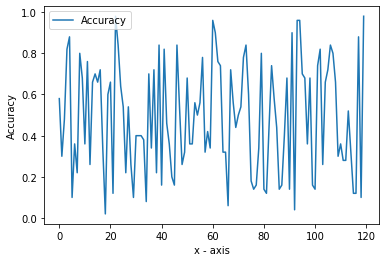

In [325]:
m = err.shape[0]
xx = np.array(list(range(0,m)))
xx = xx.reshape(m,1)
plt.plot(xx, err.reshape(m,1), label = "Accuracy")
# plt.plot(xx, y_pred.reshape(m,1), label = "Predicted")
# plt.plot(xx[0:506], y1_pred.reshape(m,1)[0:506], label = "Library")
plt.xlabel('x - axis')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [122]:
sys.maxsize

9223372036854775807

In [108]:
asss = 1
assss = 2

def ss():
    return asss+assss

In [109]:
ss()

3

In [187]:
# global trrr
trrr = np.array([0,0,0,0,0])

def addell(n):
    global trrr
#     trrr_new = trrr
    trrr = np.concatenate((trrr,[n]))
#     print(trrr)
        

In [188]:
addell(5)

In [189]:
trrr

array([0, 0, 0, 0, 0, 5])

In [178]:
trrr = np.concatenate((trrr,[5]))

In [179]:
trrr

array([0, 0, 0, 0, 0, 5, 5])

In [287]:
annots = loadmat('Archive/1.mat')
X = annots['x']
y = annots['y']

X = np.concatenate((np.ones((X.shape[0],1)), X), axis = 1)   # Adding bias to the input
y = y.reshape(y.shape[0])   # Reshaping the output array
for i in range(len(y)):   # Converting the output into a (0,1) output rather than (-1,1)
    if(y[i]==-1):
        y[i]=0
        
X.shape      

(768, 9)

In [293]:
y[:25].shape

(25,)